# Setup

In [1]:
!pip install osfclient --quiet
!pip install keras_cv --quiet
!pip install plotnine --quiet
!pip install wandb --quiet
!pip install keras-hub --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 52.2 MB/s eta 0:00:00


In [2]:
import os
from google.colab import userdata
import tensorflow as tf
import numpy as np

import keras
from keras import ops
import keras_hub
import keras_cv

import pandas as pd
import osfclient
from osfclient.api import OSF
import wandb
from wandb.integration.keras import WandbMetricsLogger

from plotnine import ggplot, geom_point, aes, geom_line, geom_histogram, geom_boxplot, geom_ribbon, scale_y_reverse, scale_y_continuous, theme_void, scale_x_continuous, scale_color_manual, scale_fill_manual, ylab, xlab, labs, theme, theme_classic, element_text, element_blank, element_line

In [3]:
!pip install git+https://github.com/jspsych/eyetracking-utils.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import et_util.dataset_utils as dataset_utils
import et_util.embedding_preprocessing as embed_pre
import et_util.model_layers as model_layers
from et_util import experiment_utils
from et_util.custom_loss import normalized_weighted_euc_dist
from et_util.model_analysis import plot_model_performance

In [5]:
os.environ['WANDB_API_KEY'] = userdata.get('WANDB_API_KEY')
os.environ['OSF_TOKEN'] = userdata.get('osftoken')
os.environ['OSF_USERNAME'] = userdata.get('osfusername')
os.environ['OSF_ANALYSIS_PROJECT_ID'] = "8ecx5"
os.environ["KERAS_BACKEND"] = "tensorflow"

# Configure W&B experiment

In [6]:
wandb.login()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [7]:
EXPERIMENT_ID = "up4mb4u3"
ENTITY_NAME = "vassar-cogsci-lab"
PROJECT_NAME = "eye-tracking-dense-full-data-set-single-eye"

# Resume the W&B run to add new data
wandb.init(entity=ENTITY_NAME, project=PROJECT_NAME, id=EXPERIMENT_ID, resume="must")

# Download the Model Config and Weights File from W&B

In [8]:
api = wandb.Api()

# https://wandb.ai/vassar-cogsci-lab/eye-tracking-dense-full-data-set-single-eye/runs/up4mb4u3?nw=nwuserjoshdeleeuw
run = api.run(f"{ENTITY_NAME}/{PROJECT_NAME}/{EXPERIMENT_ID}")

config = run.config
run.file("full_model.weights.h5").download(exist_ok=True)

EMBEDDING_DIM = config["embedding_dim"]
RIDGE_REGULARIZATION = config["ridge_regularization"]

In [9]:
# Fixed constants
MAX_TARGETS = 288

# Config constants
EMBEDDING_DIM = config['embedding_dim']
RIDGE_REGULARIZATION = config['ridge_regularization']

BACKBONE = config['backbone']

# Configure OSF Analysis Component Client

In [10]:
analysis_osf = osfclient.OSF(token=os.environ['OSF_TOKEN'])

In [11]:
analysis_osf_project = analysis_osf.project(os.environ['OSF_ANALYSIS_PROJECT_ID'])

## Function for saving files locally and uploading to OSF

In [12]:
def upload_to_analysis_osf(analysis_folder, fps):
  for fp in fps:
    local_fp = os.path.join('/content/' + analysis_folder, fp)
    remote_fp = os.path.join(analysis_folder, fp)
    with open(local_fp, 'rb') as f:
      analysis_osf_project.storage().create_file(remote_fp, fp=f, update=True)

# Dataset preparation

## Download dataset from OSF

In [13]:
!osf -p uf2sh fetch single_eye_tfrecords.tar.gz

100% 675M/675M [00:43<00:00, 15.5Mbytes/s]


# Process raw data records into TF Dataset

In [14]:
!mkdir single_eye_tfrecords
!tar -xf single_eye_tfrecords.tar.gz -C single_eye_tfrecords

In [15]:
def parse(element):
    data_structure = {
        'landmarks': tf.io.FixedLenFeature([], tf.string),
        'img_width': tf.io.FixedLenFeature([], tf.int64),
        'img_height': tf.io.FixedLenFeature([], tf.int64),
        'x': tf.io.FixedLenFeature([], tf.float32),
        'y': tf.io.FixedLenFeature([], tf.float32),
        'eye_img': tf.io.FixedLenFeature([], tf.string),
        'phase': tf.io.FixedLenFeature([], tf.int64),
        'subject_id': tf.io.FixedLenFeature([], tf.int64),
    }

    content = tf.io.parse_single_example(element, data_structure)

    #landmarks = content['landmarks']
    raw_image = content['eye_img']
    width = content['img_width']
    height = content['img_height']
    phase = content['phase']
    depth = 3
    coords = [content['x'], content['y']]
    subject_id = content['subject_id']

    # landmarks = tf.io.parse_tensor(landmarks, out_type=tf.float32)
    # landmarks = tf.reshape(landmarks, shape=(478, 3))

    image = tf.io.parse_tensor(raw_image, out_type=tf.uint8)

    return image, phase, coords, subject_id

In [16]:
test_data, _, _ = dataset_utils.process_tfr_to_tfds(
    'single_eye_tfrecords/',
    parse,
    train_split=1.0,
    val_split=0.0,
    test_split=0.0,
    random_seed=12604,
    group_function=lambda img, phase, coords, subject_id: subject_id
)

## Rescale the `x,y` coordinates to be 0-1 instead of 0-100.

In [17]:
def rescale_coords_map(img, phase, coords, id):
  return img, phase, tf.divide(coords, tf.constant([100.])), id

In [18]:
test_data_rescaled = test_data.map(rescale_coords_map)

## Prepared masked dataset with phase calibration info

In [19]:
def prepare_masked_dataset(dataset, calibration_points=None, cal_phase=None):
    # Step 1: Group dataset by subject_id and batch all images
    def group_by_subject(subject_id, ds):
        return ds.batch(batch_size=MAX_TARGETS)

    grouped_dataset = dataset.group_by_window(
        key_func=lambda img, phase, coords, subject_id: subject_id,
        reduce_func=group_by_subject,
        window_size=MAX_TARGETS
    )

    # Step 2: Filter out subjects with not enough data points （288 total; 144 in each phase)
    def filter_by_image_count(images, phase, coords, subject_ids):
        total_image_count = tf.shape(images)[0] >= MAX_TARGETS
        phase1_image_count = tf.reduce_sum(tf.cast(tf.equal(phase, 1), tf.int32)) >= 144
        phase2_image_count = tf.reduce_sum(tf.cast(tf.equal(phase, 2), tf.int32)) >= 144
        return tf.logical_and(total_image_count, tf.logical_and(phase1_image_count, phase2_image_count))

   # grouped_dataset = grouped_dataset.filter(filter_by_image_count)

    # Step 3: Transform each batch to include masks
    def add_masks_to_batch(images, phase, coords, subject_ids):

        actual_batch_size = tf.shape(images)[0] # how many total images for a given subject

        print(f'actual_batch_size: {actual_batch_size}')

        # Create phase masks
        phase1_mask = tf.cast(tf.equal(phase, 1), tf.int8)
        phase2_mask = tf.cast(tf.equal(phase, 2), tf.int8)

        cal_mask = tf.zeros(actual_batch_size, dtype=tf.int8)
        target_mask = tf.zeros(actual_batch_size, dtype=tf.int8)

        if calibration_points is None:
          raise ValueError("Need to specify calibration points in test mode")
        else:
          coords_xpand = tf.expand_dims(coords, axis=1)
          cal_xpand = tf.expand_dims(calibration_points, axis=0)

          # Check which points match calibration points
          equality = tf.equal(coords_xpand, cal_xpand)
          matches = tf.reduce_all(equality, axis=-1)
          point_matches = tf.reduce_any(matches, axis=1)
          cal_mask = tf.cast(point_matches, dtype=tf.int8)

        target_mask = (1 - cal_mask) * phase2_mask

        if cal_phase == 1:
          cal_mask = cal_mask * phase1_mask
        elif cal_phase == 2:
          cal_mask = cal_mask * phase2_mask

        padded_images = tf.pad(
            tf.reshape(images, (-1, 36, 144, 1)),
            [[0, MAX_TARGETS - actual_batch_size], [0, 0], [0, 0], [0, 0]]
        )
        padded_coords = tf.pad(
            coords,
            [[0, MAX_TARGETS - actual_batch_size], [0, 0]]
        )
        padded_cal_mask = tf.pad(
            cal_mask,
            [[0, MAX_TARGETS - actual_batch_size]]
        )
        padded_target_mask = tf.pad(
            target_mask,
            [[0, MAX_TARGETS - actual_batch_size]]
        )

        padded_images = tf.ensure_shape(padded_images, [MAX_TARGETS, 36, 144, 1])
        padded_coords = tf.ensure_shape(padded_coords, [MAX_TARGETS, 2])
        padded_cal_mask = tf.ensure_shape(padded_cal_mask, [MAX_TARGETS])
        padded_target_mask = tf.ensure_shape(padded_target_mask, [MAX_TARGETS])
        return (padded_images, padded_coords, padded_cal_mask, padded_target_mask), padded_coords, subject_ids[0]

    masked_dataset = grouped_dataset.map(
        lambda imgs, phase, coords, subj_ids: add_masks_to_batch(imgs, phase, coords, subj_ids),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return masked_dataset

In [20]:
def get_subject_id_list(features, labels, subject_ids):
  return subject_ids

In [21]:
def prepare_model_inputs(features, labels, subject_ids):
    images, coords, cal_mask, target_mask = features

    inputs = {
        "Input_All_Images": images,
        "Input_All_Coords": coords,
        "Input_Calibration_Mask": cal_mask,
        "Input_Target_Mask": target_mask
    }

    return inputs, labels, target_mask

In [22]:
cal_points = tf.constant([
    [5, 5],
    [5, 27.5],
    [5, 50],
    [5, 72.5],
    [5, 95],
    [35, 5],
    [35, 27.5],
    [35, 50],
    [35, 72.5],
    [35, 95],
    [65, 5],
    [65, 27.5],
    [65, 50],
    [65, 72.5],
    [65, 95],
    [95, 5],
    [95, 27.5],
    [95, 50],
    [95, 72.5],
    [95, 95],
], dtype=tf.float32)

scaled_cal_points = tf.divide(cal_points, tf.constant([100.]))

In [23]:
masked_dataset_p1 = prepare_masked_dataset(test_data_rescaled, scaled_cal_points, 1)

masked_dataset_p2 = prepare_masked_dataset(test_data_rescaled, scaled_cal_points, 2)

masked_dataset_subject_ids = masked_dataset_p1.map(get_subject_id_list)

actual_batch_size: Tensor("strided_slice:0", shape=(), dtype=int32)
actual_batch_size: Tensor("strided_slice:0", shape=(), dtype=int32)


In [24]:
subject_ids = []
for e in masked_dataset_subject_ids.as_numpy_iterator():
  subject_ids.append(e)
subject_ids = np.array(subject_ids).astype(int)

In [25]:
test_ds_p1 = masked_dataset_p1.map(
    prepare_model_inputs,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

test_ds_p2 = masked_dataset_p2.map(
    prepare_model_inputs,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

In [26]:
# Should be the same for either phase cal choices
SUBJECTS = 0
for e in test_ds_p1.as_numpy_iterator():
  SUBJECTS += 1

In [27]:
SUBJECTS

250

# Re-construct Model



## Custom layers

In [28]:
class SimpleTimeDistributed(keras.layers.Wrapper):
    def __init__(self, layer, **kwargs):
        super().__init__(layer, **kwargs)
        self.supports_masking = getattr(layer, 'supports_masking', False)

    def build(self, input_shape):
        if not isinstance(input_shape, (tuple, list)) or len(input_shape) < 3:
            raise ValueError(
                "`SimpleTimeDistributed` requires input with at least 3 dimensions"
            )

        super().build((input_shape[0], *input_shape[2:]))
        self.built = True

    def compute_output_shape(self, input_shape):
        child_output_shape = self.layer.compute_output_shape((input_shape[0], *input_shape[2:]))
        return (child_output_shape[0], input_shape[1], *child_output_shape[1:])

    def call(self, inputs, training=None):
        input_shape = ops.shape(inputs)
        batch_size = input_shape[0]
        time_steps = input_shape[1]

        reshaped_inputs = ops.reshape(inputs, (-1, *input_shape[2:]))

        outputs = self.layer.call(reshaped_inputs, training=training)

        output_shape = ops.shape(outputs)

        return ops.reshape(outputs, (batch_size, time_steps, *output_shape[1:]))

In [29]:
class MaskedWeightedRidgeRegressionLayer(keras.layers.Layer):
    def __init__(self, lambda_ridge, epsilon=1e-6, **kwargs):
        self.lambda_ridge = lambda_ridge
        self.epsilon = epsilon
        super(MaskedWeightedRidgeRegressionLayer, self).__init__(**kwargs)

    @tf.function
    def call(self, inputs):
        embeddings, coords, calibration_weights, cal_mask  = inputs

        embeddings = ops.cast(embeddings, "float32")
        coords = ops.cast(coords, "float32")
        calibration_weights = ops.cast(calibration_weights, "float32")
        cal_mask = ops.cast(cal_mask, "float32")

        w = ops.squeeze(calibration_weights, axis=-1)

        w_masked = w * cal_mask
        w_sqrt = ops.sqrt(w_masked + self.epsilon)
        w_sqrt = ops.expand_dims(w_sqrt, -1)

        cal_mask_expand = ops.expand_dims(cal_mask, -1)
        X = embeddings * cal_mask_expand

        X_weighted = X * w_sqrt
        y_weighted = coords * w_sqrt * cal_mask_expand

        X_t = ops.transpose(X_weighted, axes=[0, 2, 1])
        X_t_X = ops.matmul(X_t, X_weighted)

        identity_matrix = ops.cast(ops.eye(ops.shape(embeddings)[-1]), "float32")
        lhs = X_t_X + self.lambda_ridge * identity_matrix

        rhs = ops.matmul(X_t, y_weighted)

        kernel = tf.linalg.solve(lhs, rhs)

        output = ops.matmul(embeddings, kernel)

        return output


    def compute_output_shape(self, input_shapes):
        unknown_embeddings_shape, _, _, _ = input_shapes
        return unknown_embeddings_shape[:-1] + (2,)

    def get_config(self):
        config = super(MaskedWeightedRidgeRegressionLayer, self).get_config()
        config.update({"lambda_ridge": self.lambda_ridge, "epsilon": self.epsilon})
        return config

In [30]:
class MaskInspectorLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MaskInspectorLayer, self).__init__(**kwargs)
        self.supports_masking = True
    def call(self, inputs, mask=None):
      tf.print("Layer mask:", mask)
      return inputs

## Custom loss

In [31]:
def normalized_weighted_euc_dist(y_true, y_pred):
    x_weight = ops.convert_to_tensor([1.778, 1.0], dtype="float32")

    y_true_weighted = ops.multiply(x_weight, y_true)
    y_pred_weighted = ops.multiply(x_weight, y_pred)

    squared_diff = ops.square(y_pred_weighted - y_true_weighted)
    squared_dist = ops.sum(squared_diff, axis=-1)
    dist = ops.sqrt(squared_dist)

    normalized_dist = ops.divide(dist, .0203992)

    return normalized_dist

## Embedding model

In [32]:
def create_dense_net_backbone():
  DENSE_NET_STACKWISE_NUM_REPEATS = [4,4,4]
  return keras_hub.models.DenseNetBackbone(
      stackwise_num_repeats=DENSE_NET_STACKWISE_NUM_REPEATS,
      image_shape=(36, 144, 1),
  )

In [33]:
def create_embedding_model(BACKBONE):
  image_shape = (36, 144, 1)
  input_eyes = keras.layers.Input(shape=image_shape)

  eyes_rescaled = keras.layers.Rescaling(scale=1./255)(input_eyes)

  # Continue with the backbone
  # backbone = create_rednet_backbone()


  # backbone = keras.Sequential([
  #     keras.layers.Flatten(),
  #     keras.layers.Dense(10, activation="relu")
  # ])
  if BACKBONE == "densenet":
    backbone = create_dense_net_backbone()

  # backbone = create_efficientnet_backbone()

  # backbone = keras_hub.models.MiTBackbone(
  #   image_shape=(36,144,1),
  #   layerwise_depths=[2,2,2,2],
  #   num_layers=4,
  #   layerwise_num_heads=[1,2,5,8],
  #   layerwise_sr_ratios=[8,4,2,1],
  #   max_drop_path_rate=0.1,
  #   layerwise_patch_sizes=[7,3,3,3],
  #   layerwise_strides=[4,2,2,2],
  #   hidden_dims=[32,64,160,256]
  # )

  backbone_encoder = backbone(eyes_rescaled)
  flatten_compress = keras.layers.Flatten()(backbone_encoder)
  eye_embedding = keras.layers.Dense(units=EMBEDDING_DIM, activation="tanh")(flatten_compress)

  embedding_model = keras.Model(inputs=input_eyes, outputs=eye_embedding, name="Eye_Image_Embedding")

  return embedding_model

## Full trainable model

In [34]:
def create_masked_model():
    input_all_images = keras.layers.Input(
        shape=(MAX_TARGETS, 36, 144, 1),
        name="Input_All_Images"
    )

    input_all_coords = keras.layers.Input(
        shape=(MAX_TARGETS, 2),
        name="Input_All_Coords"
    )

    input_cal_mask = keras.layers.Input(
        shape=(MAX_TARGETS,),
        name="Input_Calibration_Mask",
    )

    embedding_model = create_embedding_model(BACKBONE)

    all_embeddings = SimpleTimeDistributed(embedding_model, name="Image_Embeddings")(input_all_images)

    calibration_weights = keras.layers.Dense(
        1,
        activation="sigmoid",
        name="Calibration_Weights"
    )(all_embeddings)

    ridge = MaskedWeightedRidgeRegressionLayer(
        RIDGE_REGULARIZATION,
        name="Regression"
    )(
        [
            all_embeddings,
            input_all_coords,
            calibration_weights,
            input_cal_mask,
        ],
    )

    full_model = keras.Model(
        inputs=[
            input_all_images,
            input_all_coords,
            input_cal_mask,
        ],
        outputs=ridge,
        name="MaskedEyePredictionModel"
    )

    return full_model

In [35]:
full_model = create_masked_model()
full_model.summary()

Model: "MaskedEyePredictionModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_All_Images    │ (None, 288, 36,   │          0 │ -                 │
│ (InputLayer)        │ 144, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image_Embeddings    │ (None, 288, 200)  │  1,581,896 │ Input_All_Images… │
│ (SimpleTimeDistrib… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_All_Coords    │ (None, 288, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Calibration_Weights │ (None, 288, 1)    │        201 │ Image_Embeddings… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Calibration_… │ (None, 288)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Regression          │ (None, 288, 2)    │          0 │ Image_Embeddings… │
│ (MaskedWeightedRid… │                   │            │ Input_All_Coords… │
│                     │                   │            │ Calibration_Weig… │
│                     │                   │            │ Input_Calibratio… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,582,097 (6.04 MB)

 Trainable params: 1,574,257 (6.01 MB)

 Non-trainable params: 7,840 (30.62 KB)

In [36]:
full_model.load_weights('full_model.weights.h5')
full_model.summary()

full_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=normalized_weighted_euc_dist,
    metrics=[normalized_weighted_euc_dist],
    jit_compile = False
)

Model: "MaskedEyePredictionModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_All_Images    │ (None, 288, 36,   │          0 │ -                 │
│ (InputLayer)        │ 144, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image_Embeddings    │ (None, 288, 200)  │  1,581,896 │ Input_All_Images… │
│ (SimpleTimeDistrib… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_All_Coords    │ (None, 288, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Calibration_Weights │ (None, 288, 1)    │        201 │ Image_Embeddings… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Calibration_… │ (None, 288)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Regression          │ (None, 288, 2)    │          0 │ Image_Embeddings… │
│ (MaskedWeightedRid… │                   │            │ Input_All_Coords… │
│                     │                   │            │ Calibration_Weig… │
│                     │                   │            │ Input_Calibratio… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,582,097 (6.04 MB)

 Trainable params: 1,574,257 (6.01 MB)

 Non-trainable params: 7,840 (30.62 KB)

# Analysis \#1: P1 vs P2 Subject Mean Loss Distribution

## Phase 1 calibration loss distribution across subjects

In [37]:
pred_p1 = full_model.predict(test_ds_p1.batch(5))

50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


In [38]:
# Initialize a list to store the batch losses
batch_losses_p1 = []

for pred_batch, ds_batch in zip(pred_p1, test_ds_p1.batch(1).as_numpy_iterator()):
    # Extract ground truth and subject ID from dataset batch
    y_true = ds_batch[1]
    mask = ds_batch[0]['Input_Target_Mask'].reshape(-1)

    # Calculate losses for all points in this batch
    batch_point_losses = normalized_weighted_euc_dist(y_true, pred_batch).numpy().reshape(-1)
    batch_point_losses = batch_point_losses[mask == 1]

    # Store average loss for this batch and subject ID
    batch_losses_p1.append(batch_point_losses)

In [39]:
subj_mean_losses_p1 = [np.mean(losses) for losses in batch_losses_p1]

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide


/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 4 rows containing non-finite values.


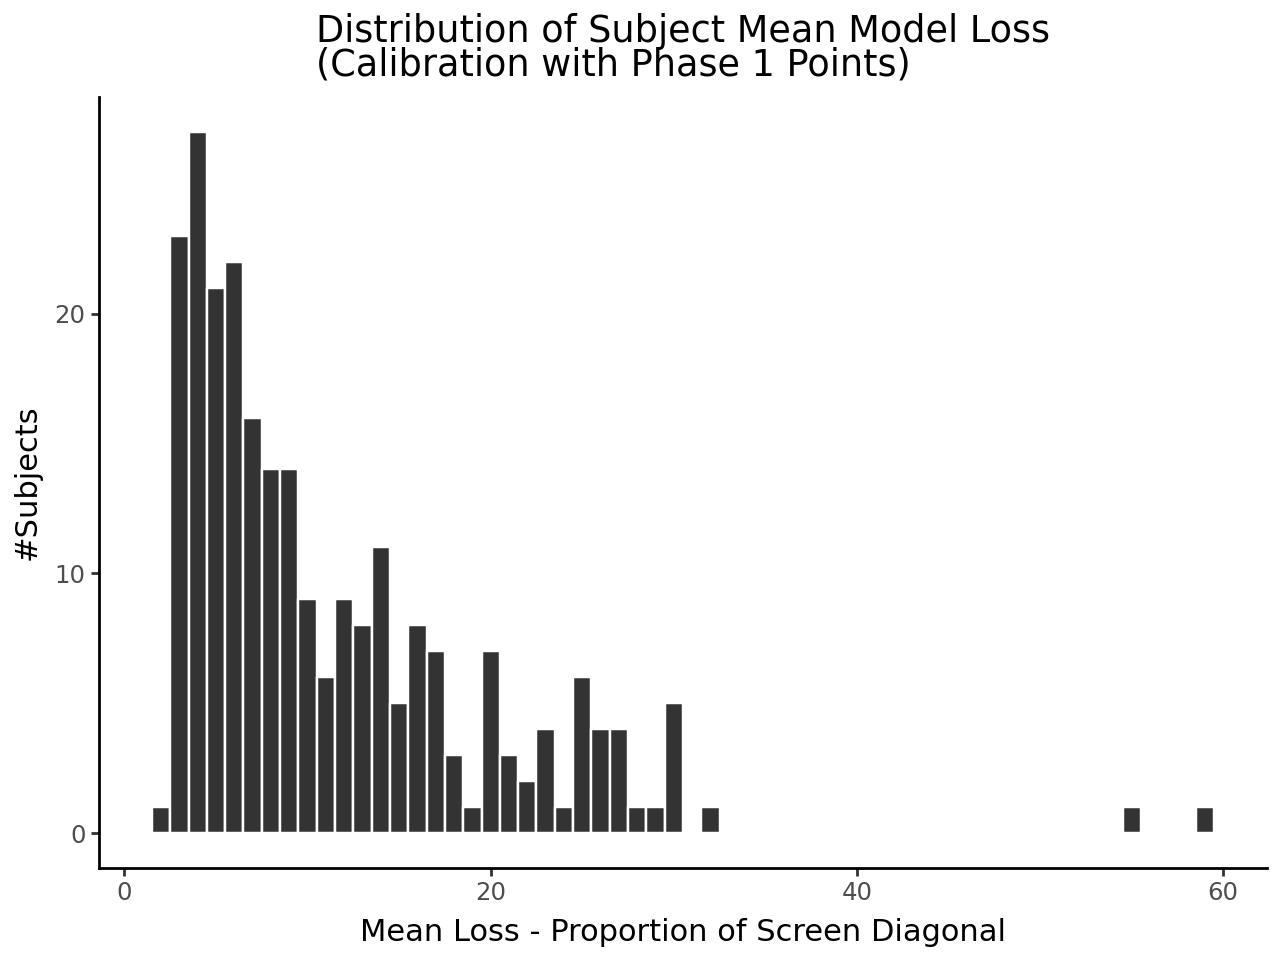

In [40]:
subj_mean_losses_df_p1 = pd.DataFrame({'mean_loss': subj_mean_losses_p1})

subj_mean_losses_plot_p1 = (ggplot(subj_mean_losses_df_p1, aes(x='mean_loss'))
 + geom_histogram(binwidth=1, color='white', fill='#333')
 + labs(title='Distribution of Subject Mean Model Loss\n(Calibration with Phase 1 Points)',
       x='Mean Loss - Proportion of Screen Diagonal',
       y='#Subjects')
 + theme_classic()
)

subj_mean_losses_plot_p1

## Phase 2 calibration loss distribution across subjects

In [41]:
pred_p2 = full_model.predict(test_ds_p2.batch(5))

50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


In [42]:
batch_losses_p2 = []
subject_ids_p2 = []

for pred_batch, ds_batch in zip(pred_p2, test_ds_p2.batch(1).as_numpy_iterator()):
    y_true = ds_batch[1]
    subject_id = ds_batch[2][0]
    mask = ds_batch[0]['Input_Target_Mask'].reshape(-1)

    batch_point_losses = normalized_weighted_euc_dist(y_true, pred_batch).numpy().reshape(-1)
    batch_point_losses = batch_point_losses[mask == 1]

    batch_losses_p2.append(batch_point_losses)
    subject_ids_p2.append(subject_id)

In [43]:
subj_mean_losses_p2 = [np.mean(losses) for losses in batch_losses_p2]

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide


/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 4 rows containing non-finite values.


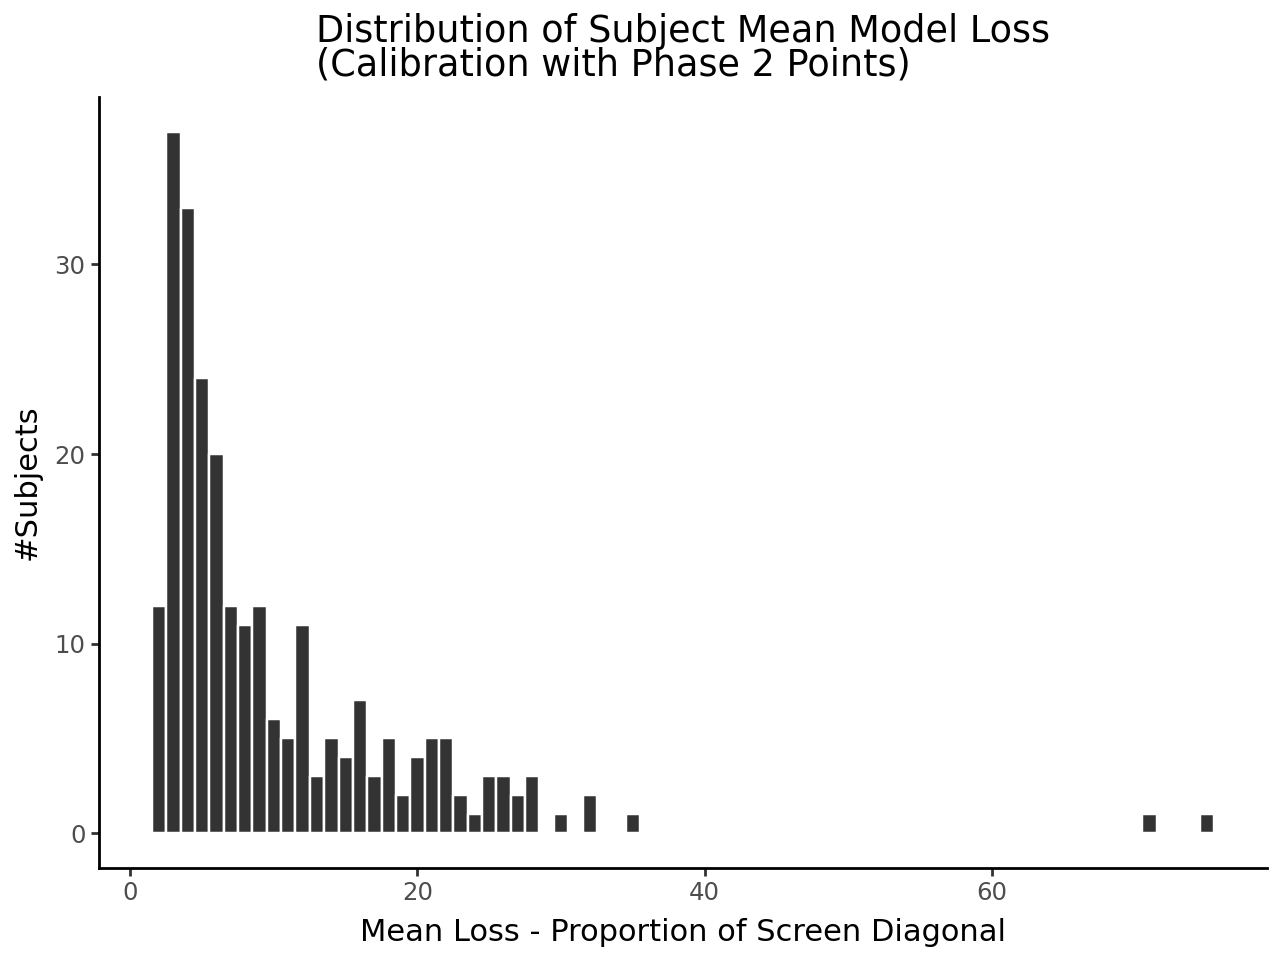

In [44]:
subj_mean_losses_df_p2 = pd.DataFrame({'mean_loss': subj_mean_losses_p2})

subj_mean_losses_plot_p2 = (ggplot(subj_mean_losses_df_p2, aes(x='mean_loss'))
 + geom_histogram(binwidth=1, color='white', fill='#333')
 + labs(title='Distribution of Subject Mean Model Loss\n(Calibration with Phase 2 Points)',
       x='Mean Loss - Proportion of Screen Diagonal',
       y='#Subjects')
 + theme_classic()
)

subj_mean_losses_plot_p2

## Create composite histogram

/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 8 rows containing non-finite values.


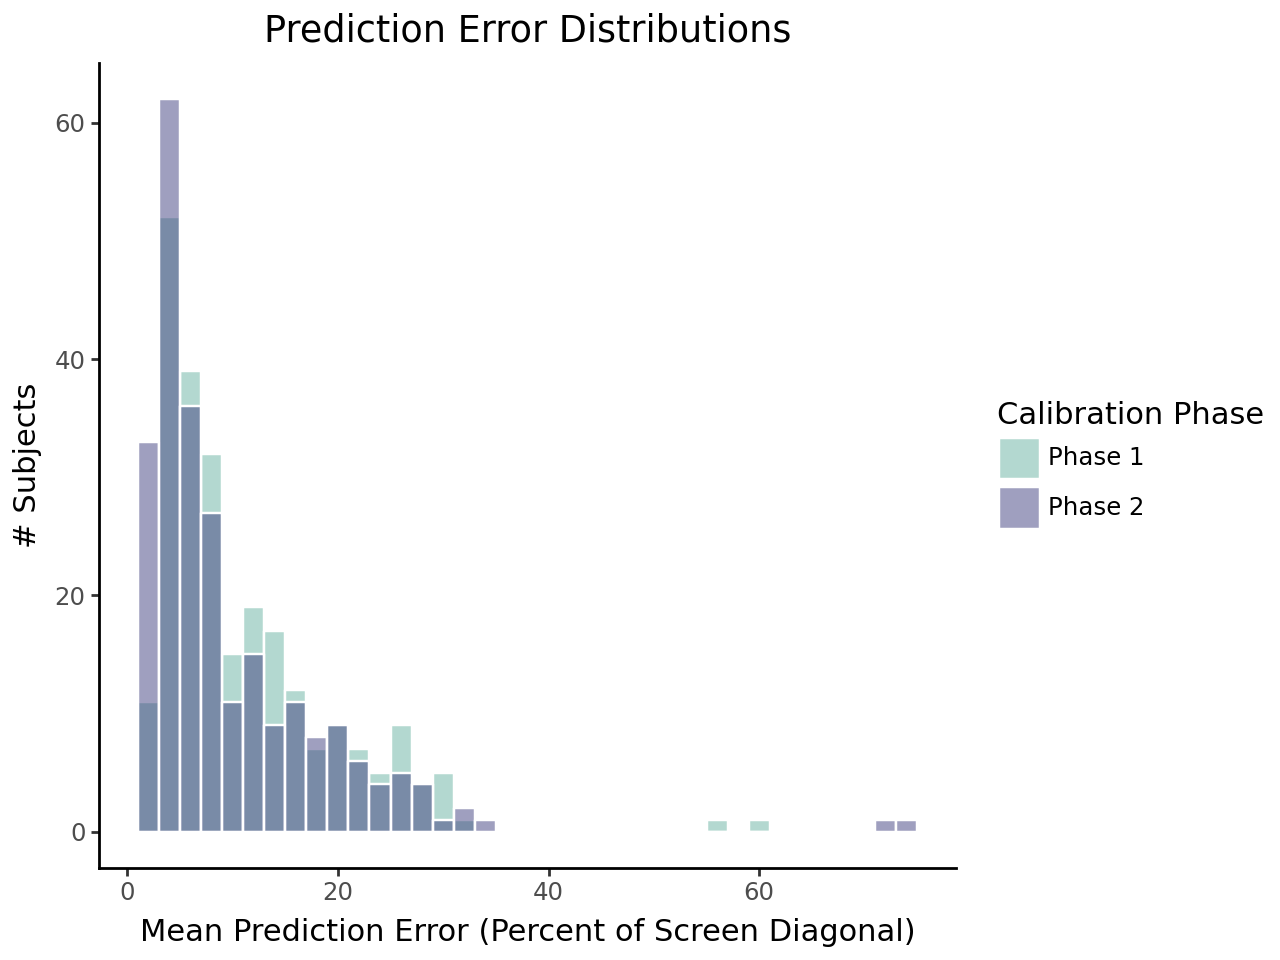

In [45]:
composite_table = pd.DataFrame({'subject_id': subject_ids, 'mean_loss_p1': subj_mean_losses_p1, 'mean_loss_p2': subj_mean_losses_p2})
composite_table_pivot_long = composite_table.melt(id_vars=['subject_id'], var_name='phase', value_name='mean_loss')

composite_plot = (ggplot(composite_table_pivot_long, aes(x='mean_loss', fill='phase'))
 + geom_histogram(binwidth=2, alpha=0.5, color='white', position="identity")
 + labs(title='Prediction Error Distributions',
       x='Mean Prediction Error (Percent of Screen Diagonal)',
       y='# Subjects')
 + scale_fill_manual(values=["#69b3a2", "#404080"], labels=["Phase 1", "Phase 2"], name="Calibration Phase")
 + theme_classic()
)

composite_plot

## Upload Analysis \#1 data to W&B

In [46]:
# Create table with subject, phase 1 loss, and phase 2 loss
analysis_1_table = wandb.Table(columns=["subject_id", "phase_1_loss", "phase_2_loss"], data=list(zip(subject_ids, subj_mean_losses_p1, subj_mean_losses_p2)))

In [47]:
analysis_1_table.data

[[np.int64(321472874995), np.float32(12.267694), np.float32(7.7909694)],
 [np.int64(1219631501545), np.float32(19.584322), np.float32(19.87769)],
 [np.int64(201649531967), np.float32(5.590574), np.float32(5.9192076)],
 [np.int64(2810238790496), np.float32(7.087137), np.float32(3.0850053)],
 [np.int64(2470764153646), np.float32(9.255426), np.float32(2.7112956)],
 [np.int64(1776705472484), np.float32(12.769492), np.float32(9.158767)],
 [np.int64(2660388343783), np.float32(8.342046), np.float32(4.4635215)],
 [np.int64(2383878767077), np.float32(7.4999866), np.float32(7.2054534)],
 [np.int64(2134511334287), np.float32(8.869812), np.float32(5.844826)],
 [np.int64(82968733662), np.float32(3.72734), np.float32(2.666921)],
 [np.int64(2265027059643), np.float32(15.877285), np.float32(10.287294)],
 [np.int64(783850052139), np.float32(4.4321933), np.float32(2.6144466)],
 [np.int64(1307111734285), np.float32(24.506361), np.float32(20.159279)],
 [np.int64(505133040007), np.float32(2.5789707), np.fl

In [48]:
wandb.log({"analysis_1_table": analysis_1_table})

In [49]:
# convert plotnine to image and save as image
composite_plot.save('analysis_1_composite_plot.png', width=10, height=5)
wandb.log({"analysis_1_histogram": wandb.Image('analysis_1_composite_plot.png')})


/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 5 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: analysis_1_composite_plot.png
/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 8 rows containing non-finite values.


# Analysis: Image Quality metrics vs. Accuracy

In [50]:
!osf -p uf2sh fetch image-quality-metrics-subject-level.csv

100% 70.0k/70.0k [00:00<00:00, 246kbytes/s]


In [51]:
df_image_quality = pd.read_csv('image-quality-metrics-subject-level.csv')

In [52]:
df_image_quality.head()

,subject_id,brightness_mean,brightness_std,contrast_mean,contrast_std,entropy_mean,entropy_std,laplacian_variance_mean,laplacian_variance_std,gradient_magnitude_mean,gradient_magnitude_std,blur_detection_mean,blur_detection_std,noise_estimation_mean,noise_estimation_std,phase_1_count,phase_2_count
0,13389585215,122.516162,2.213714,44.386757,1.586937,7.461434,0.048479,336.010478,94.648889,91.465367,7.855967,336.010478,94.648889,63.312245,1.916063,144,144
1,43470693621,117.663361,3.725072,44.106767,1.005724,7.356355,0.046730,269.278325,67.770894,85.634827,5.669005,269.278325,67.770894,63.504523,1.972885,144,144
2,45129608316,113.356417,3.033780,31.176296,2.203237,6.879860,0.089051,218.671992,63.118183,63.769301,4.658143,218.671992,63.118183,62.644547,1.635375,6,0
3,60722210910,30.975851,7.232565,18.977919,6.102619,5.785024,0.454449,99.295062,59.772809,26.010741,8.647762,99.295062,59.772809,52.333712,8.977695,138,63
4,62495457199,160.693465,12.969692,44.145459,4.755742,7.411326,0.153534,567.670864,199.714824,95.028211,10.688830,567.670864,199.714824,71.682176,3.135231,139,138


In [53]:
df_analysis_1 = pd.DataFrame({'subject_id': subject_ids, 'mean_loss_p1': subj_mean_losses_p1, 'mean_loss_p2': subj_mean_losses_p2})

In [54]:
# merge image quality data
df_analysis_1 = df_analysis_1.merge(df_image_quality, on='subject_id')

In [55]:
# run correlations for mean_loss against each quality measure
df_analysis_1.corr()

,subject_id,mean_loss_p1,mean_loss_p2,brightness_mean,brightness_std,contrast_mean,contrast_std,entropy_mean,entropy_std,laplacian_variance_mean,laplacian_variance_std,gradient_magnitude_mean,gradient_magnitude_std,blur_detection_mean,blur_detection_std,noise_estimation_mean,noise_estimation_std,phase_1_count,phase_2_count
subject_id,1.000000,0.032842,0.066170,0.052455,-0.002001,0.069444,-0.041526,0.116181,-0.056232,0.100558,0.090257,0.112833,0.040147,0.100558,0.090257,0.121501,-0.029306,0.111178,0.048362
mean_loss_p1,0.032842,1.000000,0.769780,-0.336618,0.351371,-0.272707,0.350374,-0.426858,0.466070,-0.097075,0.009648,-0.319139,0.281510,-0.097075,0.009648,-0.343556,0.406446,-0.490333,-0.540040
mean_loss_p2,0.066170,0.769780,1.000000,-0.302726,0.233415,-0.256545,0.277390,-0.347613,0.357150,-0.136989,-0.059639,-0.295115,0.155878,-0.136989,-0.059639,-0.250925,0.331272,-0.342642,-0.635753
brightness_mean,0.052455,-0.336618,-0.302726,1.000000,-0.043951,0.623027,-0.227036,0.702871,-0.503731,0.301895,0.229303,0.640956,0.019693,0.301895,0.229303,0.485018,-0.453939,0.319948,0.276228
brightness_std,-0.002001,0.351371,0.233415,-0.043951,1.000000,0.118260,0.584492,0.064992,0.444218,-0.010637,0.148315,0.012238,0.606817,-0.010637,0.148315,0.030183,0.475543,-0.088561,-0.169700
contrast_mean,0.069444,-0.272707,-0.256545,0.623027,0.118260,1.000000,-0.008885,0.857295,-0.384722,0.486135,0.470246,0.824446,0.266313,0.486135,0.470246,0.469938,-0.264018,0.291720,0.298541
contrast_std,-0.041526,0.350374,0.277390,-0.227036,0.584492,-0.008885,1.000000,-0.098139,0.561127,-0.090350,0.056889,-0.153782,0.502113,-0.090350,0.056889,-0.127370,0.530190,-0.070256,-0.104386
entropy_mean,0.116181,-0.426858,-0.347613,0.702871,0.064992,0.857295,-0.098139,1.000000,-0.604575,0.417537,0.395090,0.801521,0.210951,0.417537,0.395090,0.748813,-0.464304,0.494936,0.432550
entropy_std,-0.056232,0.466070,0.357150,-0.503731,0.444218,-0.384722,0.561127,-0.604575,1.000000,-0.222281,-0.102972,-0.443232,0.403998,-0.222281,-0.102972,-0.530470,0.875541,-0.328731,-0.300874
laplacian_variance_mean,0.100558,-0.097075,-0.136989,0.301895,-0.010637,0.486135,-0.090350,0.417537,-0.222281,1.000000,0.903746,0.703050,0.331450,1.000000,0.903746,0.561286,-0.169337,0.124478,0.148894


# Analysis \#2: P1 vs P2 Visualization for Individual Subjects

In [ ]:
subj_mean_losses_df_p1['subject_id'] = subject_ids
subj_mean_losses_df_p2['subject_id'] = subject_ids

In [ ]:
subj_mean_losses_df = pd.merge(subj_mean_losses_df_p1[subj_mean_losses_df_p1['mean_loss'] <= 15], subj_mean_losses_df_p2[subj_mean_losses_df_p2['mean_loss'] <= 15], on='subject_id', suffixes=('_p1', '_p2'))
subj_mean_losses_df['mean_loss_diff'] = abs(subj_mean_losses_df['mean_loss_p1'] - subj_mean_losses_df['mean_loss_p2'])

In [ ]:
def visualize_pred_target_diff(subject_id, subject_idx, cal_coords, phase):
  test_ds = test_ds_p1 if phase == 1 else test_ds_p2

  y_true = []

  for e in test_ds.skip(subject_idx).take(1).as_numpy_iterator():
    mask = e[0]['Input_Target_Mask'].reshape(-1)
    y_true = e[1][mask == 1]

  y_pred = full_model.predict(test_ds.skip(subject_idx).take(1).batch(1))[0]
  y_pred = y_pred[mask == 1]

  losses = normalized_weighted_euc_dist(y_true, y_pred).numpy().reshape(-1)

  cal_coords_df = pd.DataFrame({"sample": range(len(cal_coords)), "x": cal_coords[:,0], "y": cal_coords[:,1], "point_type": "calibration"})
  y_true_df = pd.DataFrame({"sample": range(len(y_true)), "x": y_true[:,0], "y": y_true[:,1], "point_type": "target"})
  y_pred_df = pd.DataFrame({"sample": range(len(y_true)), "x": y_pred[:,0], "y": y_pred[:,1], "point_type": "prediction"})

  y_df = pd.concat([cal_coords_df, y_true_df,y_pred_df])

  return (ggplot(y_df, aes(x="x", y="y", color="point_type", group="sample"))+
          geom_point()+
          geom_line(color="gray", size=0.3)+
          scale_y_reverse()+
          scale_color_manual(values=["red", "black", "gray"])+
          theme_void() +
          labs(title=f"Subject: {max_diff_row_subject_id}\n(Calibrated with phase {phase} points)"))

## Max difference subject

In [ ]:
max_diff_row_idx = subj_mean_losses_df['mean_loss_diff'].idxmax()
max_diff_row = subj_mean_losses_df.loc[max_diff_row_idx]
max_diff_row_subject_id = max_diff_row['subject_id'].astype(int)

In [ ]:
max_diff_point_loss_visualization_plot_p1 = visualize_pred_target_diff(max_diff_row_subject_id, max_diff_row_idx, scaled_cal_points, phase=1)

max_diff_point_loss_visualization_plot_p1

In [ ]:
max_diff_point_loss_visualization_plot_p2 = visualize_pred_target_diff(max_diff_row_subject_id, max_diff_row_idx, scaled_cal_points, phase=2)

max_diff_point_loss_visualization_plot_p2

## Min difference subject

In [ ]:
min_diff_row_idx = subj_mean_losses_df['mean_loss_diff'].idxmin()
min_diff_row = subj_mean_losses_df.loc[min_diff_row_idx]
min_diff_row_subject_id = min_diff_row['subject_id'].astype(int)

In [ ]:
min_diff_point_loss_visualization_plot_p1 = visualize_pred_target_diff(min_diff_row_subject_id, min_diff_row_idx, scaled_cal_points, phase=1)

min_diff_point_loss_visualization_plot_p1

In [ ]:
min_diff_point_loss_visualization_plot_p2 = visualize_pred_target_diff(min_diff_row_subject_id, min_diff_row_idx, scaled_cal_points, phase=2)

min_diff_point_loss_visualization_plot_p2

## Best subject

In [ ]:
subj_mean_losses_df['total_loss'] = subj_mean_losses_df['mean_loss_p1'] + subj_mean_losses_df['mean_loss_p2']

best_subj_row_idx = subj_mean_losses_df['total_loss'].idxmin()
best_subj_row = subj_mean_losses_df.loc[best_subj_row_idx]
best_subj_row_subject_id = best_subj_row['subject_id'].astype(int)

In [ ]:
best_subj_point_loss_visualization_plot_p1 = visualize_pred_target_diff(best_subj_row_subject_id, best_subj_row_idx, scaled_cal_points, phase=1)

best_subj_point_loss_visualization_plot_p1

In [ ]:
best_subj_point_loss_visualization_plot_p2 = visualize_pred_target_diff(best_subj_row_subject_id, best_subj_row_idx, scaled_cal_points, phase=2)

best_subj_point_loss_visualization_plot_p2

## Worst subject

In [ ]:
worst_subj_row_idx = subj_mean_losses_df['total_loss'].idxmax()
worst_subj_row = subj_mean_losses_df.loc[worst_subj_row_idx]
worst_subj_row_subject_id = worst_subj_row['subject_id'].astype(int)

In [ ]:
worst_subj_point_loss_visualization_plot_p1 = visualize_pred_target_diff(worst_subj_row_subject_id, worst_subj_row_idx, scaled_cal_points, phase=1)

worst_subj_point_loss_visualization_plot_p1

In [ ]:
worst_subj_point_loss_visualization_plot_p2 = visualize_pred_target_diff(worst_subj_row_subject_id, worst_subj_row_idx, scaled_cal_points, phase=2)

worst_subj_point_loss_visualization_plot_p2

## Upload Analysis \#2 data to OSF

In [ ]:
os.makedirs("analysis_2", exist_ok=True)

In [ ]:
max_diff_point_loss_visualization_plot_p1.save('analysis_2/max_diff_point_loss_visualization_plot_p1.png')

max_diff_point_loss_visualization_plot_p2.save('analysis_2/max_diff_point_loss_visualization_plot_p2.png')

min_diff_point_loss_visualization_plot_p1.save('analysis_2/min_diff_point_loss_visualization_plot_p1.png')

min_diff_point_loss_visualization_plot_p2.save('analysis_2/min_diff_point_loss_visualization_plot_p2.png')

best_subj_point_loss_visualization_plot_p1.save('analysis_2/best_subj_point_loss_visualization_plot_p1.png')

best_subj_point_loss_visualization_plot_p2.save('analysis_2/best_subj_point_loss_visualization_plot_p2.png')

worst_subj_point_loss_visualization_plot_p1.save('analysis_2/worst_subj_point_loss_visualization_plot_p1.png')

worst_subj_point_loss_visualization_plot_p2.save('analysis_2/worst_subj_point_loss_visualization_plot_p2.png')

In [ ]:
upload_to_analysis_osf("analysis_2", [
    "max_diff_point_loss_visualization_plot_p1.png",
    "max_diff_point_loss_visualization_plot_p2.png",
    "min_diff_point_loss_visualization_plot_p1.png",
    "min_diff_point_loss_visualization_plot_p2.png",
    "best_subj_point_loss_visualization_plot_p1.png",
    "best_subj_point_loss_visualization_plot_p2.png",
    "worst_subj_point_loss_visualization_plot_p1.png",
    "worst_subj_point_loss_visualization_plot_p2.png"
])

# Analysis \#3: Eye Images Animated Visualization for Different Loss Ranges

In [ ]:
os.makedirs("analysis_3", exist_ok=True)

In [ ]:
subj_losses_df_p1 = pd.DataFrame({'subject_id': subject_ids, 'losses': batch_losses_p1})
subj_losses_df_p1 = subj_losses_df_p1[subj_losses_df_p1['losses'].apply(len) >= 124]
subj_losses_df_p1['mean_loss'] = subj_losses_df_p1['losses'].apply(np.mean)

In [ ]:
losses_array = np.array(subj_losses_df_p1['losses'].to_list())

In [ ]:
subj_mean_losses_df_5 = subj_losses_df_p1[(subj_losses_df_p1['mean_loss'] >= 4) & (subj_losses_df_p1['mean_loss'] <= 6)]

subj_mean_losses_df_10 = subj_losses_df_p1[(subj_losses_df_p1['mean_loss'] >= 8) & (subj_losses_df_p1['mean_loss'] <= 12)]

subj_mean_losses_df_15 = subj_losses_df_p1[(subj_losses_df_p1['mean_loss'] >= 14) & (subj_losses_df_p1['mean_loss'] <= 16)]

subj_mean_losses_df_20 = subj_losses_df_p1[(subj_losses_df_p1['mean_loss'] >= 19) & (subj_losses_df_p1['mean_loss'] <= 21)]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import base64

def visualize_eye_tracking_data(dataset, subject_id, mean_loss, filename, interval=50, figsize=(10, 6)):
    # Extract data from the dataset
    for inputs, labels, _ in dataset.take(1):
        images = inputs["Input_All_Images"]
        coords = inputs["Input_All_Coords"]

        # Convert to numpy arrays
        valid_images = images.numpy()
        valid_coords = coords.numpy()

        # Sort by X coordinate, then by Y coordinate
        sorted_indices = np.lexsort((valid_coords[:, 0], valid_coords[:, 1]))
        valid_images = valid_images[sorted_indices]
        valid_coords = valid_coords[sorted_indices]

        num_images = valid_images.shape[0]

    # Set up the figure
    plt.ioff()  # Turn off interactive mode to avoid displaying during generation
    fig, ax = plt.subplots(figsize=figsize)

    # Create a function that draws each frame
    def draw_frame(frame_num):
        ax.clear()

        # Set up the 16:9 coordinate space
        ax.set_xlim(0, 100)
        ax.set_ylim(100, 0)  # 16:9 aspect ratio

        # Get the current image and coordinates
        img = valid_images[frame_num].squeeze()
        x, y = valid_coords[frame_num]

        # Draw rectangle for the screen
        rect = plt.Rectangle((0, 0), 100, 100, fill=False, color='black', linewidth=2)
        ax.add_patch(rect)

        # Add image display in the top right corner
        img_display = ax.inset_axes([0.35, 0.35, 0.3, 0.3], transform=ax.transAxes)
        img_display.imshow(np.fliplr(img), cmap='gray')
        img_display.axis('off')

        # Draw red dot at the coordinate - make it bigger for visibility
        ax.scatter(x * 100, y * 100, color='red', s=150, zorder=5,
                  edgecolor='white', linewidth=1.5)

        # Draw crosshair
        ax.axhline(y * 100, color='gray', linestyle='--', alpha=0.5, zorder=1)
        ax.axvline(x * 100, color='gray', linestyle='--', alpha=0.5, zorder=1)

        # Set title
        ax.set_title(f'Eye Tracking Visualization\nSubject: {subject_id}\nMean Loss: {mean_loss}')

        # Set axis labels
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')

    # Create the animation
    anim = animation.FuncAnimation(fig, draw_frame, frames=num_images, interval=interval)

    anim.save(filename, writer="pillow")

  # Use animation's to_jshtml method which directly generates HTML
    html_animation = anim.to_jshtml()

    # Clean up
    plt.close(fig)

    # Create an HTML object that can be displayed in the notebook
    return HTML(html_animation)

## Loss ~5

In [ ]:
rand_loss_5_row = subj_mean_losses_df_5.sample(n=1)
rand_loss_5_idx = rand_loss_5_row.index[0]
rand_loss_5_id = rand_loss_5_row['subject_id'].iloc[0].astype(int)
rand_loss_5_mean_loss = rand_loss_5_row['mean_loss'].iloc[0]

In [ ]:
eye_animation_loss_5 = visualize_eye_tracking_data(test_ds_p1.skip(rand_loss_5_idx).take(1), rand_loss_5_id, rand_loss_5_mean_loss, "analysis_3/eye_animation_loss_5.gif")
eye_animation_loss_5

## Loss ~10

In [ ]:
rand_loss_10_row = subj_mean_losses_df_10.sample(n=1)
rand_loss_10_idx = rand_loss_10_row.index[0]
rand_loss_10_id = rand_loss_10_row['subject_id'].iloc[0].astype(int)
rand_loss_10_mean_loss = rand_loss_10_row['mean_loss'].iloc[0]

In [ ]:
eye_animation_loss_10 = visualize_eye_tracking_data(test_ds_p1.skip(rand_loss_10_idx).take(1), rand_loss_10_id, rand_loss_10_mean_loss, "analysis_3/eye_animation_loss_10.gif")
eye_animation_loss_10

## Loss ~15

In [ ]:
rand_loss_15_row = subj_mean_losses_df_15.sample(n=1)
rand_loss_15_idx = rand_loss_15_row.index[0]
rand_loss_15_id = rand_loss_15_row['subject_id'].iloc[0].astype(int)
rand_loss_15_mean_loss = rand_loss_15_row['mean_loss'].iloc[0]

In [ ]:
eye_animation_loss_15 = visualize_eye_tracking_data(test_ds_p1.skip(rand_loss_15_idx).take(1), rand_loss_15_id, rand_loss_15_mean_loss, "analysis_3/eye_animation_loss_15.gif")
eye_animation_loss_15

## Loss ~20

In [ ]:
rand_loss_20_row = subj_mean_losses_df_20.sample(n=1)
rand_loss_20_idx = rand_loss_20_row.index[0]
rand_loss_20_id = rand_loss_20_row['subject_id'].iloc[0].astype(int)
rand_loss_20_mean_loss = rand_loss_20_row['mean_loss'].iloc[0]

In [ ]:
eye_animation_loss_20 = visualize_eye_tracking_data(test_ds_p1.skip(rand_loss_20_idx).take(1), rand_loss_20_id, rand_loss_20_mean_loss, "analysis_3/eye_animation_loss_20.gif")
eye_animation_loss_20

## Best Subject

In [ ]:
eye_animation_loss_best_subj = visualize_eye_tracking_data(test_ds_p1.skip(best_subj_row_idx).take(1), best_subj_row_subject_id, subj_mean_losses_df.iloc[best_subj_row_idx]['mean_loss_p1'], "analysis_3/eye_animation_best_subj.gif")
eye_animation_loss_best_subj

## Worst Subject (for losses between 0 and 15 in both phases)

In [ ]:
eye_animation_loss_worst_subj = visualize_eye_tracking_data(test_ds_p1.skip(worst_subj_row_idx).take(1), worst_subj_row_subject_id, subj_mean_losses_df.iloc[worst_subj_row_idx]['mean_loss_p1'], "analysis_3/eye_animation_worst_subj.gif")
eye_animation_loss_worst_subj

## Upload Analysis \#3 data to OSF

In [ ]:
upload_to_analysis_osf("analysis_3", [
    "eye_animation_loss_5.gif",
    "eye_animation_loss_10.gif",
    "eye_animation_loss_15.gif",
    "eye_animation_loss_20.gif",
    "eye_animation_best_subj.gif",
    "eye_animation_worst_subj.gif"
])

# Analysis \#4: Effect of number of calibration points on model performance

## Grab dataset from OSF

In [ ]:
!osf -p th7fv fetch  model_losses_across_cal_configs_df.csv

In [ ]:
model_losses_across_cal_configs_df = pd.read_csv('model_losses_across_cal_configs_df.csv')
model_losses_across_cal_configs_df

## Calibration points

In [ ]:
cols = [5, 11, 17, 23, 29, 35, 41, 47, 53, 59, 65, 71, 77, 83, 89, 95]
rows = [5, 16.25, 27.5, 38.75, 50, 61.25, 72.5, 83.75, 95]

cal_cols = [5, 35, 65, 95]
cal_rows = [5, 27.5, 50, 72.5, 95]

In [ ]:
all_points = [[a, b] for a in cols for b in rows]
cal_points = [[c, d] for c in cal_cols for d in cal_rows]

In [ ]:
cols_cols_indices = [
    [0,15],
    [0,7,15],
    [0,5,10,15],
    [0,4,8,12,15],
    [0,3,6,9,12,15],
    [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
]

rows_rows_indices = [
    [0,8],
    [0,4,8],
    [0,2,4,6,8],
    [0,1,2,3,4,5,6,7,8]
]

In [ ]:
cols_rows_indices = [
    [tf.constant([cols[x],rows[y]], dtype=tf.float32)
    for x in cols_indices for y in rows_indices]
    for cols_indices in cols_cols_indices for rows_indices in rows_rows_indices
    ]

In [ ]:
cols_rows_indices = sorted(cols_rows_indices, key=lambda x: len(x))
for i, config in enumerate(cols_rows_indices):
  if i > 0 and len(config) == len(cols_rows_indices[i-1]):
    cols_rows_indices.pop(i)
cols_rows_indices = cols_rows_indices[:-1]

In [ ]:
cols_rows_indices_scaled = [tf.divide(config, tf.constant([100.])) for config in cols_rows_indices]

In [ ]:
len(list(zip(*all_points)))

In [ ]:
# import matplotlib.pyplot as plt

# def visualize_points(points):
#   plt.figure(figsize=(16, 9))
#   x_coords, y_coords = list(zip(*points))
#   x_all, y_all = list(zip(*all_points))
#   plt.scatter(x_all, y_all, alpha=0.3)
#   plt.scatter(x_coords, y_coords, c='black')

#   # Set x and y ticks to be the rows and cols
#   plt.xticks(cols)
#   plt.yticks(rows)
#   plt.xlabel("% of screen width", fontsize=16)
#   plt.ylabel("% of screen height", fontsize=16)
#   plt.title("Calibration Points", fontsize=20)
#   plt.show()

In [ ]:
def visualize_points(points):
  df_all = pd.DataFrame(all_points, columns=['x', 'y'])
  df_all['type'] = 'all_points'
  df_points = pd.DataFrame(points, columns=['x', 'y'])
  df_points['type'] = 'calibration_points'
  df = pd.concat([df_all, df_points])

  plot = (ggplot(df, aes(x='x', y='y', color='type'))
          + geom_point()
          + scale_x_continuous(breaks=cols)
          + scale_color_manual(values=["black", "red"])
          + scale_y_continuous(breaks=rows, trans='reverse') # Reverse y-axis
          + labs(x='% of screen width', y='% of screen height', title='Calibration Points', color="")
          + theme_classic()
         )
  return plot

In [ ]:
cal_points_visualization = visualize_points(cal_points)

## Filter function for subjects missing calibration points

In [ ]:
def filter_by_n_cal_points(features, labels, subject_ids, cal_points):
  n_cal_points = len(cal_points)
  images, coords, cal_mask, target_mask = features

  return tf.equal(tf.reduce_sum(cal_mask, axis=-1), n_cal_points)


## Phase 1 boxplot across \# cal points

In [ ]:
batch_losses_across_cal_p1 = []
for i, cal_config in enumerate(cols_rows_indices_scaled):
  # Make masked dataset with the cal_config
  masked_dataset_p1_config = prepare_masked_dataset(test_data_rescaled, cal_config, 1)

  masked_dataset_p1_config_filtered = masked_dataset_p1_config.filter(
      lambda features, labels, subject_ids: filter_by_n_cal_points(
          features, labels, subject_ids, cal_config)
  )

  test_ds_p1_config = masked_dataset_p1_config_filtered.map(
      prepare_model_inputs,
      num_parallel_calls=tf.data.AUTOTUNE
  ).prefetch(tf.data.AUTOTUNE)

  # Get predictions
  predictions_p1_config = full_model.predict(test_ds_p1_config.batch(BATCH_SIZE))

  batch_losses_p1_config = []

  for pred_batch, ds_batch in zip(predictions_p1_config, test_ds_p1_config.batch(1).as_numpy_iterator()):
      y_true = ds_batch[1]
      mask = ds_batch[0]['Input_Target_Mask'].reshape(-1)

      batch_point_losses = normalized_weighted_euc_dist(y_true, pred_batch).numpy().reshape(-1)
      batch_point_losses = batch_point_losses[mask == 1]

      batch_losses_p1_config.append(batch_point_losses)
  batch_losses_across_cal_p1.append((cal_config, batch_losses_p1_config))

In [ ]:
num_cal_points = [len(cal_config) for cal_config, _ in batch_losses_across_cal_p1]

In [ ]:
model_losses_p1 = [batch_losses for _, batch_losses in batch_losses_across_cal_p1]

In [ ]:
model_losses_df_data_p1 = []
for i, cal_config in enumerate(model_losses_p1):  # Iterate through 19 cal_configs
  for j, subject_model_losses in enumerate(cal_config): # Iterate through 146 subjects
      img_count = np.count_nonzero(~np.isnan(subject_model_losses))
      row = {
          'num_cal_points': num_cal_points[i],
          'subject_id': j,
          'img_count': img_count,
          'subj_mean_loss': np.mean(subject_model_losses)}
      row.update({'point_' + str(k) + '_loss': val for k, val in enumerate(subject_model_losses)})
      model_losses_df_data_p1.append(row)

model_losses_df_p1 = pd.DataFrame(model_losses_df_data_p1)
model_losses_df_p1 = model_losses_df_p1.sort_values(by=['num_cal_points', 'subject_id'])

In [ ]:
model_losses_df_sorted_p1 = model_losses_df_p1.sort_values(by='num_cal_points')

ordered_cal_points_p1 = sorted(model_losses_df_p1['num_cal_points'].unique())
ordered_cal_points_str_p1 = [str(x) for x in ordered_cal_points_p1]

model_losses_df_sorted_p1['num_cal_points_cat'] = pd.Categorical(
    model_losses_df_sorted_p1['num_cal_points'].astype(str),
    categories=ordered_cal_points_str_p1,
    ordered=True
)

model_losses_across_cal_configs_p1_boxplot = (
    ggplot(model_losses_df_sorted_p1, aes(x='num_cal_points_cat', y='subj_mean_loss'))
    + geom_boxplot()
    + labs(
        title="Model Error Across Number of Calibration Points",
        x="#Calibration points",
        y="Model error"
    )
    + theme_classic()
    + theme(
        plot_title=element_text(hjust=0.5),
        axis_text_x=element_text(angle=45, hjust=1)
    )
)

model_losses_across_cal_configs_p1_boxplot

## Phase 2 boxplot across \# cal points

In [ ]:
batch_losses_across_cal_p2 = []
for i, cal_config in enumerate(cols_rows_indices_scaled):
  # Make masked dataset with the cal_config
  masked_dataset_p2_config = prepare_masked_dataset(test_data_rescaled, cal_config, 2)

  masked_dataset_p2_config_filtered = masked_dataset_p2_config.filter(
      lambda features, labels, subject_ids: filter_by_n_cal_points(
          features, labels, subject_ids, cal_config)
  )

  test_ds_p2_config = masked_dataset_p2_config_filtered.map(
      prepare_model_inputs,
      num_parallel_calls=tf.data.AUTOTUNE
  ).prefetch(tf.data.AUTOTUNE)

  # Get predictions
  predictions_p2_config = full_model.predict(test_ds_p2_config.batch(BATCH_SIZE))

  batch_losses_p2_config = []

  for pred_batch, ds_batch in zip(predictions_p2_config, test_ds_p2_config.batch(1).as_numpy_iterator()):
      y_true = ds_batch[1]
      mask = ds_batch[0]['Input_Target_Mask'].reshape(-1)

      batch_point_losses = normalized_weighted_euc_dist(y_true, pred_batch).numpy().reshape(-1)
      batch_point_losses = batch_point_losses[mask == 1]

      batch_losses_p2_config.append(batch_point_losses)
  batch_losses_across_cal_p2.append((cal_config, batch_losses_p2_config))

In [ ]:
model_losses_p2 = [batch_losses for _, batch_losses in batch_losses_across_cal_p2]

In [ ]:
model_losses_df_data_p2 = []
for i, cal_config in enumerate(model_losses_p2):  # Iterate through 19 cal_configs
  for j, subject_model_losses in enumerate(cal_config): # Iterate through 146 subjects
      img_count = np.count_nonzero(~np.isnan(subject_model_losses))
      row = {
          'num_cal_points': num_cal_points[i],
          'subject_id': j,
          'img_count': img_count,
          'subj_mean_loss': np.mean(subject_model_losses)}
      row.update({'point_' + str(k) + '_loss': val for k, val in enumerate(subject_model_losses)})
      model_losses_df_data_p2.append(row)

model_losses_df_p2 = pd.DataFrame(model_losses_df_data_p2)
model_losses_df_p2 = model_losses_df_p2.sort_values(by=['num_cal_points', 'subject_id'])

In [ ]:
model_losses_df_sorted_p2 = model_losses_df_p2.sort_values(by='num_cal_points')

ordered_cal_points_p2 = sorted(model_losses_df_p2['num_cal_points'].unique())
ordered_cal_points_str_p2 = [str(x) for x in ordered_cal_points_p2]

model_losses_df_sorted_p2['num_cal_points_cat'] = pd.Categorical(
    model_losses_df_sorted_p2['num_cal_points'].astype(str),
    categories=ordered_cal_points_str_p2,
    ordered=True
)

model_losses_across_cal_configs_p2_boxplot = (
    ggplot(model_losses_df_sorted_p2, aes(x='num_cal_points_cat', y='subj_mean_loss'))
    + geom_boxplot()
    + labs(
        title="Model Error Across Number of Calibration Points",
        x="#Calibration points",
        y="Model error"
    )
    + theme_classic()
    + theme(
        plot_title=element_text(hjust=0.5),
        axis_text_x=element_text(angle=45, hjust=1)
    )
)

model_losses_across_cal_configs_p2_boxplot

## Phase 1+2 boxplot across \# cal points

In [ ]:
masked_dataset_pboth_cal_config = prepare_masked_dataset(test_data_rescaled, cols_rows_indices_scaled[3])

masked_dataset_pboth_cal_config_filtered = masked_dataset_pboth_cal_config.filter(
    lambda features, labels, subject_ids: filter_by_n_cal_points(
        features, labels, subject_ids, cols_rows_indices_scaled[3])
)

test_ds_pboth_cal_config = masked_dataset_pboth_cal_config_filtered.map(
    prepare_model_inputs,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create a small subset dataset to test with
test_dataset = masked_dataset_p1_cal_config.take(1)

# Force execution by consuming some elements
for batch_idx, (data, coords, subject_id) in enumerate(masked_dataset_pboth_cal_config):
    (images, batch_coords, cal_mask, target_mask) = data

    print(f"Batch {batch_idx}")
    print(f"Subject ID: {subject_id.numpy()}")
    print(f"Cal mask sum: {tf.reduce_sum(cal_mask).numpy()}")
    print(f"Target mask sum: {tf.reduce_sum(target_mask).numpy()}")
    print("----------------------------")

In [ ]:
pred_p1_both = full_model.predict(test_ds_pboth_cal_config.batch(BATCH_SIZE))

In [ ]:
items = []
for e in test_ds_pboth_cal_config.as_numpy_iterator():
  items.append(e[0])

In [ ]:
len(items)

In [ ]:
batch_losses_across_cal_pboth = []
for i, cal_config in enumerate(cols_rows_indices_scaled):
  masked_dataset_pboth_config = prepare_masked_dataset(test_data_rescaled, cal_config, cal_phase=None)

  masked_dataset_pboth_config_filtered = masked_dataset_pboth_config.filter(
      lambda features, labels, subject_ids: filter_by_n_cal_points(
          features, labels, subject_ids, cal_config)
  )

  test_ds_pboth_config = masked_dataset_pboth_config_filtered.map(
      prepare_model_inputs,
      num_parallel_calls=tf.data.AUTOTUNE
  ).prefetch(tf.data.AUTOTUNE)

  predictions_pboth_config = full_model.predict(test_ds_pboth_config.batch(BATCH_SIZE))

  batch_losses_pboth_config = []

  for pred_batch, ds_batch in zip(predictions_pboth_config, test_ds_pboth_config.batch(1).as_numpy_iterator()):
      y_true = ds_batch[1]
      mask = ds_batch[0]['Input_Target_Mask'].reshape(-1)

      batch_point_losses = normalized_weighted_euc_dist(y_true, pred_batch).numpy().reshape(-1)
      batch_point_losses = batch_point_losses[mask == 1]

      batch_losses_pboth_config.append(batch_point_losses)
  batch_losses_across_cal_pboth.append((cal_config, batch_losses_pboth_config))

In [ ]:
model_losses_pboth = [batch_losses for _, batch_losses in batch_losses_across_cal_pboth]

In [ ]:
model_losses_df_data_pboth = []
for i, cal_config in enumerate(model_losses_pboth):  # Iterate through 19 cal_configs
  for j, subject_model_losses in enumerate(cal_config): # Iterate through 146 subjects
      img_count = np.count_nonzero(~np.isnan(subject_model_losses))
      row = {
          'num_cal_points': num_cal_points[i],
          'subject_id': j,
          'img_count': img_count,
          'subj_mean_loss': np.mean(subject_model_losses)}
      row.update({'point_' + str(k) + '_loss': val for k, val in enumerate(subject_model_losses)})
      model_losses_df_data_pboth.append(row)

model_losses_df_pboth = pd.DataFrame(model_losses_df_data_pboth)
model_losses_df_pboth = model_losses_df_pboth.sort_values(by=['num_cal_points', 'subject_id'])

In [ ]:
model_losses_df_pboth.to_csv('model_losses_across_cal_configs_pboth_df.csv')

In [ ]:
model_losses_df_sorted_phase_both = model_losses_df_phase_both.sort_values(by='num_cal_points')

ordered_cal_points_phase_both = sorted(model_losses_df_phase_both['num_cal_points'].unique())
ordered_cal_points_str_phase_both = [str(x) for x in ordered_cal_points_phase_both]

model_losses_df_sorted_phase_both['num_cal_points_cat'] = pd.Categorical(
    model_losses_df_sorted_phase_both['num_cal_points'].astype(str),
    categories=ordered_cal_points_str_phase_both,
    ordered=True
)

model_losses_across_cal_configs_phase_both_boxplot = (
    ggplot(model_losses_df_sorted_phase_both, aes(x='num_cal_points_cat', y='subj_mean_loss'))
    + geom_boxplot()
    + labs(
        title="Model Error Across Number of Calibration Points",
        x="#Calibration points",
        y="Model error"
    )
    + theme_classic()
    + theme(
        plot_title=element_text(hjust=0.5),
        axis_text_x=element_text(angle=45, hjust=1)
    )
)

model_losses_across_cal_configs_phase_both_boxplot

## Save Analysis \#4 data and upload to OSF

In [ ]:
os.makedirs("analysis_4", exist_ok=True)

In [ ]:
cal_points_visualization.save('analysis_4/cal_points_visualization.png')

In [ ]:
model_losses_df_p1.to_csv('analysis_4/model_losses_across_cal_configs_p1_df.csv')
model_losses_df_p2.to_csv('analysis_4/model_losses_across_cal_configs_p2_df.csv')
# model_losses_df_pboth.to_csv('model_losses_across_cal_configs_pboth_df.csv')

In [ ]:
model_losses_across_cal_configs_p1_boxplot.save('analysis_4/model_losses_across_cal_configs_p1_boxplot.png')
model_losses_across_cal_configs_p2_boxplot.save('analysis_4/model_losses_across_cal_configs_p2_boxplot.png')

In [ ]:
upload_to_analysis_osf("analysis_4", [
    "cal_points_visualization.png",
    "model_losses_across_cal_configs_p1_boxplot.png",
    "model_losses_across_cal_configs_p2_boxplot.png",
    "model_losses_across_cal_configs_p1_df.csv",
    "model_losses_across_cal_configs_p2_df.csv"
])

# Analysis \#5: Ribbont Plot Across #Cal Points

## Phase 1 ribbon plot across \# cal points

In [ ]:
model_losses_df_sorted_p1['mean_loss'] = model_losses_df_sorted_p1.groupby('num_cal_points')['subj_mean_loss'].transform('mean')
model_losses_df_sorted_p1['median_loss'] = model_losses_df_sorted_p1.groupby('num_cal_points')['subj_mean_loss'].transform('median')
model_losses_df_sorted_p1['min_loss'] = model_losses_df_sorted_p1.groupby('num_cal_points')['subj_mean_loss'].transform('min')
model_losses_df_sorted_p1['max_loss'] = model_losses_df_sorted_p1.groupby('num_cal_points')['subj_mean_loss'].transform('max')

In [ ]:
model_losses_df_sorted_p1

In [ ]:
model_losses_df_sorted_p1['2_50 loss'] = model_losses_df_sorted_p1.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 2.5))
model_losses_df_sorted_p1['12_5 loss'] = model_losses_df_sorted_p1.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 12.5))
model_losses_df_sorted_p1['25_0 loss'] = model_losses_df_sorted_p1.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 25))
model_losses_df_sorted_p1['75_0 loss'] = model_losses_df_sorted_p1.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 75))
model_losses_df_sorted_p1['87_5 loss'] = model_losses_df_sorted_p1.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 87.5))
model_losses_df_sorted_p1['97_5 loss'] = model_losses_df_sorted_p1.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 97.5))

In [ ]:
model_losses_df_sorted_p1

In [ ]:
ribbon_map = {'2.5% to 97.5%': '#b8f7ff', '12.5% to 87.5%': '#8dc1fc', '25% to 75%': '#5d68de'}

model_losses_across_cal_configs_ribbon_plot_phase1 = (
    ggplot(model_losses_df_sorted_p1, aes(x='num_cal_points')) +
    geom_ribbon(aes(ymin='2_50 loss', ymax='97_5 loss', fill='"2.5% to 97.5%"'), alpha=0.6) +
    geom_ribbon(aes(ymin='12_5 loss', ymax='87_5 loss', fill='"12.5% to 87.5%"'), alpha=0.6) +
    geom_ribbon(aes(ymin='25_0 loss', ymax='75_0 loss', fill='"25% to 75%"'), alpha=0.6) +
    geom_line(aes(y='median_loss'), color='#333', size=1) +
    geom_point(aes(y='median_loss'), size=1, alpha=0.05, color='#333') +
    geom_point(aes(x='num_cal_points', y='min_loss'), size=0.5, alpha=0.05) +
    geom_point(aes(x='num_cal_points', y='max_loss'), size=0.5, alpha=0.05) +
    scale_x_continuous(breaks=(4,8,15,20,25,30,36,45,54,80,144), limits=(None, 80)) +
    scale_fill_manual(
        name="% of subjects",
        values=ribbon_map
    ) +
    labs(
        x='#Calibration Points',
        y='Model loss',
        title='Loss Distribution across different #calibration points (Phase 1)'
    ) +
    theme(
        panel_grid=element_blank(),
        panel_background=element_blank(),
        plot_background=element_blank(),
        axis_line=element_line(color='black', size=1),
        axis_text_x=element_text(hjust=1),
        axis_title=element_text(),
        plot_title=element_text(),
        legend_title=element_text(size=10),
        legend_text=element_text(size=8),
        legend_position="bottom"
    )
)

model_losses_across_cal_configs_ribbon_plot_phase1

## Phase 2 ribbon plot across \# cal points

In [ ]:
model_losses_df_sorted_p2['mean_loss'] = model_losses_df_sorted_p2.groupby('num_cal_points')['subj_mean_loss'].transform('mean')
model_losses_df_sorted_p2['median_loss'] = model_losses_df_sorted_p2.groupby('num_cal_points')['subj_mean_loss'].transform('median')
model_losses_df_sorted_p2['min_loss'] = model_losses_df_sorted_p2.groupby('num_cal_points')['subj_mean_loss'].transform('min')
model_losses_df_sorted_p2['max_loss'] = model_losses_df_sorted_p2.groupby('num_cal_points')['subj_mean_loss'].transform('max')

In [ ]:
model_losses_df_sorted_p2['2_50 loss'] = model_losses_df_sorted_p2.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 2.5))
model_losses_df_sorted_p2['12_5 loss'] = model_losses_df_sorted_p2.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 12.5))
model_losses_df_sorted_p2['25_0 loss'] = model_losses_df_sorted_p2.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 25))
model_losses_df_sorted_p2['75_0 loss'] = model_losses_df_sorted_p2.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 75))
model_losses_df_sorted_p2['87_5 loss'] = model_losses_df_sorted_p2.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 87.5))
model_losses_df_sorted_p2['97_5 loss'] = model_losses_df_sorted_p2.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 97.5))

In [ ]:
ribbon_map = {'2.5% to 97.5%': '#b8f7ff', '12.5% to 87.5%': '#8dc1fc', '25% to 75%': '#5d68de'}

model_losses_across_cal_configs_ribbon_plot_phase2 = (
    ggplot(model_losses_df_sorted_p2, aes(x='num_cal_points')) +
    geom_ribbon(aes(ymin='2_50 loss', ymax='97_5 loss', fill='"2.5% to 97.5%"'), alpha=0.6) +
    geom_ribbon(aes(ymin='12_5 loss', ymax='87_5 loss', fill='"12.5% to 87.5%"'), alpha=0.6) +
    geom_ribbon(aes(ymin='25_0 loss', ymax='75_0 loss', fill='"25% to 75%"'), alpha=0.6) +
    geom_line(aes(y='median_loss'), color='#333', size=1) +
    geom_point(aes(y='median_loss'), size=1, alpha=0.05, color='#333') +
    geom_point(aes(x='num_cal_points', y='min_loss'), size=0.5, alpha=0.05) +
    geom_point(aes(x='num_cal_points', y='max_loss'), size=0.5, alpha=0.05) +
    scale_x_continuous(breaks=(4,8,15,20,25,30,36,45,54,80,144), limits=(None, 80)) +
    scale_fill_manual(
        name="% of subjects",
        values=ribbon_map
    ) +
    labs(
        x='#Calibration Points',
        y='Model loss',
        title='Loss Distribution across different #calibration points (Phase 2)'
    ) +
    theme(
        panel_grid=element_blank(),
        panel_background=element_blank(),
        plot_background=element_blank(),
        axis_line=element_line(color='black', size=1),
        axis_text_x=element_text(hjust=1),
        axis_title=element_text(),
        plot_title=element_text(),
        legend_title=element_text(size=10),
        legend_text=element_text(size=8),
        legend_position="bottom"
    )
)

model_losses_across_cal_configs_ribbon_plot_phase2

## Phase 1+2 ribbon plot across \# cal points

In [ ]:
model_losses_df_phase_both['mean_loss'] = model_losses_df_phase_both.groupby('num_cal_points')['subj_mean_loss'].transform('mean')
model_losses_df_phase_both['median_loss'] = model_losses_df_phase_both.groupby('num_cal_points')['subj_mean_loss'].transform('median')
model_losses_df_phase_both['min_loss'] = model_losses_df_phase_both.groupby('num_cal_points')['subj_mean_loss'].transform('min')
model_losses_df_phase_both['max_loss'] = model_losses_df_phase_both.groupby('num_cal_points')['subj_mean_loss'].transform('max')

In [ ]:
model_losses_df_phase_both['2_50 loss'] = model_losses_df_phase_both.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 2.5))
model_losses_df_phase_both['12_5 loss'] = model_losses_df_phase_both.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 12.5))
model_losses_df_phase_both['25_0 loss'] = model_losses_df_phase_both.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 25))
model_losses_df_phase_both['75_0 loss'] = model_losses_df_phase_both.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 75))
model_losses_df_phase_both['87_5 loss'] = model_losses_df_phase_both.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 87.5))
model_losses_df_phase_both['97_5 loss'] = model_losses_df_phase_both.groupby('num_cal_points')['subj_mean_loss'].transform(lambda x: np.percentile(x, 97.5))

In [ ]:
model_losses_df_phase_both

In [ ]:
ribbon_map = {'2.5% to 97.5%': '#b8f7ff', '12.5% to 87.5%': '#8dc1fc', '25% to 75%': '#5d68de'}

model_losses_across_cal_configs_ribbon_plot_phase_both = (
    ggplot(model_losses_df_phase_both, aes(x='num_cal_points')) +
    geom_ribbon(aes(ymin='2_50 loss', ymax='97_5 loss', fill='"2.5% to 97.5%"'), alpha=0.6) +
    geom_ribbon(aes(ymin='12_5 loss', ymax='87_5 loss', fill='"12.5% to 87.5%"'), alpha=0.6) +
    geom_ribbon(aes(ymin='25_0 loss', ymax='75_0 loss', fill='"25% to 75%"'), alpha=0.6) +
    geom_line(aes(y='median_loss'), color='#333', size=1) +
    geom_point(aes(y='median_loss'), size=1, alpha=0.05, color='#333') +
    geom_point(aes(x='num_cal_points', y='min_loss'), size=0.5, alpha=0.05) +
    geom_point(aes(x='num_cal_points', y='max_loss'), size=0.5, alpha=0.05) +
    scale_x_continuous(breaks=(4,8,15,20,25,30,36,45,54,80,144), limits=(None, 144)) +
    scale_fill_manual(
        name="% of subjects",
        values=ribbon_map
    ) +
    labs(
        x='#Calibration Points',
        y='Model loss',
        title='Loss Distribution across different #calibration points (Phase 2)'
    ) +
    theme(
        panel_grid=element_blank(),
        panel_background=element_blank(),
        plot_background=element_blank(),
        axis_line=element_line(color='black', size=1),
        axis_text_x=element_text(hjust=1),
        axis_title=element_text(),
        plot_title=element_text(),
        legend_title=element_text(size=10),
        legend_text=element_text(size=8),
        legend_position="bottom"
    )
)

model_losses_across_cal_configs_ribbon_plot_phase_both

## Save Analysis \#5 data and upload to OSF

In [ ]:
os.makedirs("analysis_5", exist_ok=True)

In [ ]:
model_losses_across_cal_configs_ribbon_plot_phase1.save('analysis_5/model_losses_across_cal_configs_ribbon_plot_phase1.png')
model_losses_across_cal_configs_ribbon_plot_phase2.save('analysis_5/model_losses_across_cal_configs_ribbon_plot_phase2.png')

In [ ]:
upload_to_analysis_osf("analysis_5", [
    "model_losses_across_cal_configs_ribbon_plot_phase1.png",
    "model_losses_across_cal_configs_ribbon_plot_phase2.png"
])

# Effect of glasses on model performance

In [ ]:
!osf -p uf2sh fetch glasses_info.csv

In [ ]:
glasses_df = pd.read_csv('glasses_info.csv')
glasses_df['subject_b36'] = glasses_df['subject_id'].apply(lambda x: int(x, 36))
glasses_df['wore_glasses'] = glasses_df['wore_glasses'].apply(lambda x: True if x == 'yes' else False)

In [ ]:
losses_df = pd.DataFrame(columns=["subject_b36", "batch_loss"])
losses_df["subject_b36"] = subject_ids
losses_df['batch_loss'] = batch_losses

In [ ]:
validation_glasses_df = pd.merge(glasses_df, losses_df, on='subject_b36', how="inner")
validation_glasses_df = validation_glasses_df.drop(['subject_id'], axis=1)
validation_glasses_only_df = validation_glasses_df[validation_glasses_df['wore_glasses'] == True]
validation_no_glasses_df = validation_glasses_df[validation_glasses_df['wore_glasses'] == False]

In [ ]:
validation_glasses_df

In [ ]:
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(
    [validation_glasses_only_df['batch_loss'], validation_no_glasses_df['batch_loss']],
    bins=np.arange(0.01,0.23, 0.01),
    edgecolor='white',
    label=['Wore glasses', 'Did not wear glasses'],
    color=['#333', '#AAA'])
plt.title('Effect of Wearing Glasses on Model Error')
plt.xlabel('Avg. Error - Proportion of Screen Diagonal')
plt.ylabel('# subjects')
plt.legend()
plt.show()

# Spread out vs focused calibration

In [ ]:
middle_cols = [29, 47, 53, 71]
middle_rows = [27.5, 50, 72.5,]
middle_cols_rows_indices = [tf.constant([x, y], dtype=tf.float32) for y in middle_rows for x in middle_cols]
middle_cols_rows_indices_scaled = tf.divide(middle_cols_rows_indices, tf.constant([100.]))

## filter before running predictions

In [ ]:
middle_cols_full = [29, 35, 41, 47, 53, 59, 65, 71]
middle_rows_full = [27.5, 38.75, 50, 61.25, 72.5,]
middle_cols_rows_indices_full = [tf.constant([x, y], dtype=tf.float32) for y in middle_rows_full for x in middle_cols_full]
middle_cols_rows_indices_full_scaled = tf.divide(middle_cols_rows_indices_full, tf.constant([100.]))

In [ ]:
def middle_filter_cal_points(image, mesh, coords, id):

  return tf.reduce_any(tf.reduce_all(tf.equal(coords, middle_cols_rows_indices_full_scaled), axis=1))

def middle_reducer_function_fixed_pts_with_id(subject_id, ds):

  non_cal_points = ds.batch(144, drop_remainder=True).map(map_for_non_calibration_pts)

  points = ds.filter(middle_filter_cal_points).batch(len(middle_cols_rows_indices_full)).map(map_for_calibration_pts).repeat()

  merged = tf.data.Dataset.zip(points, non_cal_points)

  return merged.map(lambda x, y: map_for_merged_with_id(x, y, subject_id))

## filter after running predictions

In [ ]:
cal_points = middle_cols_rows_indices
scaled_cal_points = middle_cols_rows_indices_scaled
v = validation_data_rescaled.group_by_window(
    key_func = lambda img, m, c, z: z,
    reduce_func = reducer_function_fixed_pts_with_id,
    window_size = 200
).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
middle_batch_losses = []
middle_subject_ids = []
middle_y_true = []
filtered_y_true = []

for e in v.batch(1).as_numpy_iterator():
    middle_y_true.append(e[1])
    middle_subject_ids.append(e[2][0])

middle_y_true = np.array(middle_y_true).reshape(-1, 144, 2)
middle_predictions = full_model.predict(v.batch(1))

for i in range(len(middle_predictions)): # 153
  loss = normalized_weighted_euc_dist(middle_y_true[i], middle_predictions[i]).numpy()
  new_loss = []
  new_y_true = []
  for j, trial_loss in enumerate(loss): # 144
    if (middle_y_true[i][j][0] > 0.25 and
        middle_y_true[i][j][0] < 0.75 and
        middle_y_true[i][j][1] > 0.17 and
        middle_y_true[i][j][1] < 0.83):
      new_loss.append(trial_loss)
      new_y_true.append(middle_y_true[i][j])
  filtered_y_true.append(new_y_true)
  middle_batch_losses.append(new_loss)

middle_batch_losses = np.array(middle_batch_losses)

# Get mean per subject
middle_batch_losses = np.mean(middle_batch_losses, axis=1)

In [ ]:
outer_cols = [5, 17, 29, 41, 59, 71, 83, 95]
outer_rows = [5, 27.25, 50, 72.5, 95]
outer_cols_rows_indices = [tf.constant([x, y], dtype=tf.float32) for y in outer_rows for x in outer_cols]
outer_cols_rows_indices_scaled = tf.divide(outer_cols_rows_indices, tf.constant([100.]))

In [ ]:
cal_points = outer_cols_rows_indices
scaled_cal_points = outer_cols_rows_indices_scaled
v = validation_data_rescaled.group_by_window(
    key_func = lambda img, m, c, z: z,
    reduce_func = reducer_function_fixed_pts_with_id,
    window_size = 200
).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
outer_batch_losses = []
outer_subject_ids = []
outer_y_true = []
filtered_y_true = []

for e in v.batch(1).as_numpy_iterator():
    outer_y_true.append(e[1])
    outer_subject_ids.append(e[2][0])

outer_y_true = np.array(outer_y_true).reshape(-1, 144, 2)
outer_predictions = full_model.predict(v.batch(1))

for i in range(len(outer_predictions)): # 153
  loss = normalized_weighted_euc_dist(outer_y_true[i], outer_predictions[i]).numpy()
  new_loss = []
  new_y_true = []
  for j, trial_loss in enumerate(loss): # 144
    if (outer_y_true[i][j][0] > 0.25 and
        outer_y_true[i][j][0] < 0.75 and
        outer_y_true[i][j][1] > 0.17 and
        outer_y_true[i][j][1] < 0.83):
      new_loss.append(trial_loss)
      new_y_true.append(outer_y_true[i][j])
  filtered_y_true.append(new_y_true)
  outer_batch_losses.append(new_loss)

outer_batch_losses = np.array(outer_batch_losses)

# Get mean per subject
outer_batch_losses = np.mean(outer_batch_losses, axis=1)

In [ ]:
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(
    [middle_batch_losses, outer_batch_losses],
    bins=np.arange(0.01,0.23, 0.01),
    color=['#333', '#AAA'],
    edgecolor='white',
    label=['Focused calibration', 'Spread out calibration'])
plt.title('Focused vs. Spread out calibration')
plt.xlabel('Avg. Error - Proportion of Screen Diagonal')
plt.ylabel('# subjects')
plt.legend()
plt.show()

# Horizontal AOIs vs Vertical AOIs

In [ ]:
cols = [5, 11, 17, 23, 29, 35, 41, 47, 53, 59, 65, 71, 77, 83, 89, 95]
rows = [5, 16.25, 27.5, 38.75, 50, 61.25, 72.5, 83.75, 95]
total_points = tf.constant([[col, row] for col in cols for row in rows], dtype=tf.float32)

In [ ]:
cal_points = tf.constant([
    [5, 5],
    [5, 27.5],
    [5, 50],
    [5, 72.5],
    [5, 95],
    [35, 5],
    [35, 27.5],
    [35, 50],
    [35, 72.5],
    [35, 95],
    [65, 5],
    [65, 27.5],
    [65, 50],
    [65, 72.5],
    [65, 95],
    [95, 5],
    [95, 27.5],
    [95, 50],
    [95, 72.5],
    [95, 95],
], dtype=tf.float32)

scaled_cal_points = tf.divide(cal_points, tf.constant([100.]))

In [ ]:
v = validation_data_rescaled.group_by_window(
    key_func = lambda img, m, c, z: z,
    reduce_func = reducer_function_fixed_pts_with_id,
    window_size = 200
).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# Initialize a list to store the batch losses
subject_ids = []
y_true = []

for e in v.batch(1).as_numpy_iterator():

    y_true.append(e[1])
    subject_ids.append(e[2][0])

y_true = np.array(y_true).reshape(-1, 144, 2)

# this step is slower than expected. not sure what's going on.
predictions = full_model.predict(v.batch(1))

In [ ]:
batch_losses = []
x_losses = []
y_losses = []

for i in range(len(predictions)): #153
  loss = normalized_weighted_euc_dist(y_true[i], predictions[i]).numpy()
  subject_x_loss = []
  subject_y_loss = []
  for j in range(len(predictions[i])): #144
    subject_trial_x_loss = abs(predictions[i][j][0] - y_true[i][j][0])
    subject_trial_y_loss = abs(predictions[i][j][1] - y_true[i][j][1])
    subject_x_loss.append(subject_trial_x_loss)
    subject_y_loss.append(subject_trial_y_loss)
    # subject_x_loss.append(subject_trial_x_loss if subject_trial_x_loss < 0.12 else float('nan'))
    # subject_y_loss.append(subject_trial_y_loss if subject_trial_y_loss < 0.12 else float('nan'))
  x_losses.append(subject_x_loss)
  y_losses.append(subject_y_loss)
  batch_losses.append(loss)

batch_losses = np.array(batch_losses)
x_losses = np.array(x_losses)
y_losses = np.array(y_losses)

In [ ]:
x_y_losses = np.sqrt(np.add(np.square(y_losses.ravel()), np.square(x_losses.ravel())))

In [ ]:
x_losses = x_losses.ravel()
y_losses = y_losses.ravel()

In [ ]:
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(y_losses, bins=np.arange(0,0.2, 0.001), edgecolor='white')
plt.title('Histogram of Model Error')
plt.xlabel('Avg. Error - Proportion of Screen Diagonal')
plt.ylabel('# subjects')
plt.show()

In [ ]:
x_losses_sorted = []
y_losses_sorted = []
y_true_subject_sorted = []
for y_true_subject, *loss_arrays in zip(y_true, *[x_losses, y_losses]):
  sorted_indices = sorted(range(len(y_true_subject)), key=lambda i: (y_true_subject[i][0], y_true_subject[i][1]))
  y_true_subject_sorted.append([y_true_subject[i] for i in sorted_indices])
  x_losses_sorted.append([loss_arrays[0][i] for i in sorted_indices])
  y_losses_sorted.append([loss_arrays[1][i] for i in sorted_indices])

In [ ]:
x_losses_avg = np.nanmean(x_losses_sorted, axis=0)
y_losses_avg = np.nanmean(y_losses_sorted, axis=0)

In [ ]:
x_losses_avg = x_losses_avg.reshape(9, 16)
y_losses_avg = y_losses_avg.reshape(9, 16)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(x_losses_avg, vmin=0, vmax=0.12, cmap="RdYlBu_r")

ax.set_xticks(np.arange(len(cols)), labels=cols)
ax.set_yticks(np.arange(len(rows)), labels=rows)


# Loop over data dimensions and create text annotations.
for i in range(len(rows)):
    for j in range(len(cols)):
        text = ax.text(j, i, np.round(x_losses_avg[i, j], decimals=2),
                       ha="center", va="center", color="k")

ax.set_title("Horizontal Loss")
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(y_losses_avg, vmin=0, vmax=0.12, cmap="RdYlBu_r")

ax.set_xticks(np.arange(len(cols)), labels=cols)
ax.set_yticks(np.arange(len(rows)), labels=rows)


# Loop over data dimensions and create text annotations.
for i in range(len(rows)):
    for j in range(len(cols)):
        text = ax.text(j, i, np.round(y_losses_avg[i, j], decimals=2),
                       ha="center", va="center", color="k")

ax.set_title("Vertical Loss")
fig.tight_layout()
plt.show()

In [ ]:
x_y_losses_avg = np.sqrt(np.add(np.square(y_losses_avg), np.square(x_losses_avg)))

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(x_y_losses_avg, vmin=0, vmax=0.12, cmap="RdYlBu_r")

ax.set_xticks(np.arange(len(cols)), labels=cols)
ax.set_yticks(np.arange(len(rows)), labels=rows)


# Loop over data dimensions and create text annotations.
for i in range(len(rows)):
    for j in range(len(cols)):
        text = ax.text(j, i, np.round(x_y_losses_avg[i, j], decimals=2),
                       ha="center", va="center", color="k")

ax.set_title("Horizontal + Vertical Loss")
fig.tight_layout()
plt.show()